In [1]:
# Importing all requisite libraries, settings some overall parameters and formatting.
%reset -f
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
import plotly
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
from pandas_profiling import ProfileReport
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import leafmap
import datapane
pd.set_option('max_columns', 20)
pd.set_option('max_rows', 20)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set_style('darkgrid');

In [2]:
# Create the SQLAlchemy engine to read in .db data to a pandas dataframe
engine = create_engine("sqlite:////Users/nathanieldirenzo/Documents/GitHub/NYC_MTA_EDA_Project/mta_data.db")

In [3]:
# Create pandas dataframe 
df = pd.read_sql('SELECT * FROM mta_data;', engine)

In [4]:
# An extra SQL query to demonstrate that a majority of the EDA done below is do-able in SQL.
df2 = pd.read_sql('select *, ENTRIES - coalesce(lag(ENTRIES) over (ORDER BY "C/A", UNIT, SCP, STATION, DATE, TIME), 0) AS NET_ENTRIES, EXITS - coalesce(lag(EXITS) over (ORDER BY "C/A", UNIT, SCP, STATION, DATE, TIME), 0) AS NET_EXITS from mta_data  order by "C/A", UNIT, SCP, STATION, DATE, TIME LIMIT 100;', engine)
df2.head()


C/A  UNIT       SCP STATION LINENAME DIVISION        DATE      TIME  \
0  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/01/2021  03:00:00   
1  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/01/2021  07:00:00   
2  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/01/2021  11:00:00   
3  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/01/2021  15:00:00   
4  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/01/2021  19:00:00   

      DESC  ENTRIES    EXITS  NET_ENTRIES  NET_EXITS  
0  REGULAR  7511448  2558786      7511448    2558786  
1  REGULAR  7511451  2558789            3          3  
2  REGULAR  7511461  2558813           10         24  
3  REGULAR  7511495  2558831           34         18  
4  REGULAR  7511620  2558857          125         26

In [5]:
#Pandas-profiling report. Commented out when not actively being used.
#profile = ProfileReport(df)
#profile

In [6]:
# Rename df columns to make them easier to work wit
df = df.rename(columns={'C/A': 'control_area', 'UNIT': 'unit', 'SCP': 'subunit_channel_pos', 'STATION':'station', 'LINENAME':'subway_lines', 'DIVISION':'division', 'DATE':'date', 'TIME':'time', 'DESC':'desc', 'ENTRIES':'entries', 'EXITS':'exits'})

In [7]:
# Reformatting column names
df.station = df.station.str.replace("/","_")
df.station = df.station.str.replace("-","_")
df.station = df.station.str.replace(" ","_")
df.station = df.station.str.lower()

In [8]:
df['date'] = df['date'].str.replace('/','_')
df['time'] = df['time'].str.replace(':','_')
df['desc'] = df['desc'].str.replace(' ', '_')
df['subunit_channel_pos'] = df['subunit_channel_pos'].str.replace('-', '_')

In [9]:
df['unique_id'] = df['control_area'] + '_' + df['unit'] + '_' + df['subunit_channel_pos'] + '_' + df['station'] + '_' + df['date'] + '_' + df['time'] + '_' + df['desc']

In [10]:
df['date_time'] = df.date + ' ' + df.time

In [11]:
df.date_time = pd.to_datetime(df['date_time'], format = '%m_%d_%Y %H_%M_%S')

In [12]:
# In my initial findings, Recovery Audits were difficult to work with as they were irregular, often had large, seemingly inaccurate counts, 
# and could occur at the same time and location as Regular audits. I've chosen to elimate them from my dataset for uniformity's sake.
df = df[df.desc != 'RECOVR_AUD']

In [13]:
# Creating the Net_Entries, Net_Exits, and Net_Traffic columns-- which are foundational to the rest of the analysis
df['net_entries'] = df.groupby(['control_area', 'unit', 'subunit_channel_pos', 'station'])['entries'].transform(lambda x: x.diff())
df['net_exits'] = df.groupby(['control_area', 'unit', 'subunit_channel_pos', 'station'])['exits'].transform(lambda x: x.diff())
df['net_traffic'] = df.net_entries + df.net_exits

In [14]:
# Elimating turnstiles that count in reverse by casting all values as absolutes.
df['net_entries'] = abs(df.net_entries)
df['net_exits'] = abs(df.net_exits)
df['net_traffic'] = abs(df.net_traffic)

(array([-5.0e+08,  0.0e+00,  5.0e+08,  1.0e+09,  1.5e+09,  2.0e+09,
         2.5e+09,  3.0e+09,  3.5e+09,  4.0e+09]),
 [Text(-500000000.0, 0, '−500000000'),
  Text(0.0, 0, '0'),
  Text(500000000.0, 0, '500000000'),
  Text(1000000000.0, 0, '1000000000'),
  Text(1500000000.0, 0, '1500000000'),
  Text(2000000000.0, 0, '2000000000'),
  Text(2500000000.0, 0, '2500000000'),
  Text(3000000000.0, 0, '3000000000'),
  Text(3500000000.0, 0, '3500000000'),
  Text(4000000000.0, 0, '4000000000')])

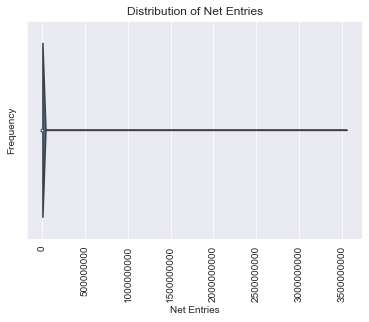

In [15]:
sns.violinplot(x=df.net_traffic);
plt.ticklabel_format(axis='x', style='plain');
plt.title('Distribution of Net Entries');
plt.xlabel('Net Entries');
plt.ylabel('Frequency');
plt.savefig('violin_before.png');
plt.xticks(rotation=90)

In [16]:
# NaN's should only be at the beginning of each turnstile's rows, so we will fill those values with 0's
df.fillna(0, inplace=True)

In [17]:
# Elimate outliers in the data by reducing to the 99th percentile. This is an unsophisticated method, and an area for potential improvement.
q = np.nanquantile(df["net_entries"], .99)
df = df[df["net_entries"] < q]

q2 = np.nanquantile(df["net_exits"], .99)
df = df[df["net_exits"] < q2]

q3 = np.nanquantile(df['net_traffic'], .99)
df=df[df['net_traffic'] < q3]

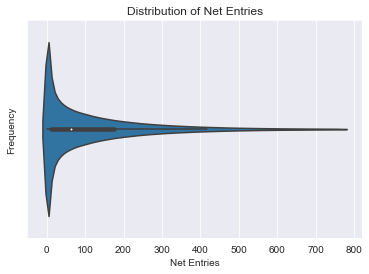

In [18]:
sns.violinplot(x=df.net_traffic);
plt.ticklabel_format(axis='x', style='plain');
plt.title('Distribution of Net Entries');
plt.xlabel('Net Entries');
plt.ylabel('Frequency');
plt.savefig('violin_after.png');

In [19]:
df['date'] = df.date_time.dt.date

In [20]:
df['day_of_week'] = df.date_time.dt.dayofweek

In [21]:
df['month'] = df.date_time.dt.month

In [22]:
df['week'] = df.date_time.dt.isocalendar().week

In [23]:
df['hour'] = df.date_time.dt.hour

In [24]:
hourly_df = df.groupby(['hour'])[['net_traffic']].mean().reset_index()

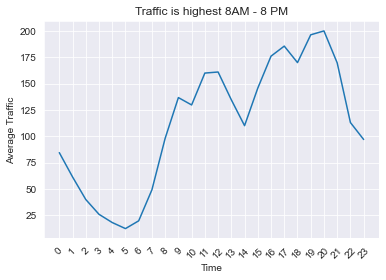

In [25]:
plt.plot(hourly_df.hour,hourly_df.net_traffic);
plt.xlabel('Time')
plt.ylabel('Average Traffic')
plt.title('Traffic is highest 8AM - 8 PM')
plt.xticks(np.arange(24), rotation=45);
plt.savefig('trafficbyhour.png');

In [26]:
daily_timelapse_df = df.groupby(['date'])[['net_traffic']].mean().reset_index()
daily_timelapse_df['pct_change'] = daily_timelapse_df.net_traffic.pct_change()

In [27]:
weekly_timelapse_df = df.groupby(['week'])[['net_traffic']].sum().reset_index().copy()
weekly_timelapse_df['pct_change'] = weekly_timelapse_df.net_traffic.pct_change()
weekly_timelapse_df['pct_change'].iloc[0] = 0
weekly_timelapse_df['pct_total'] = weekly_timelapse_df['net_traffic'].apply(lambda x: x / weekly_timelapse_df.net_traffic.sum())

/Users/nathanieldirenzo/opt/anaconda3/envs/geo_env/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


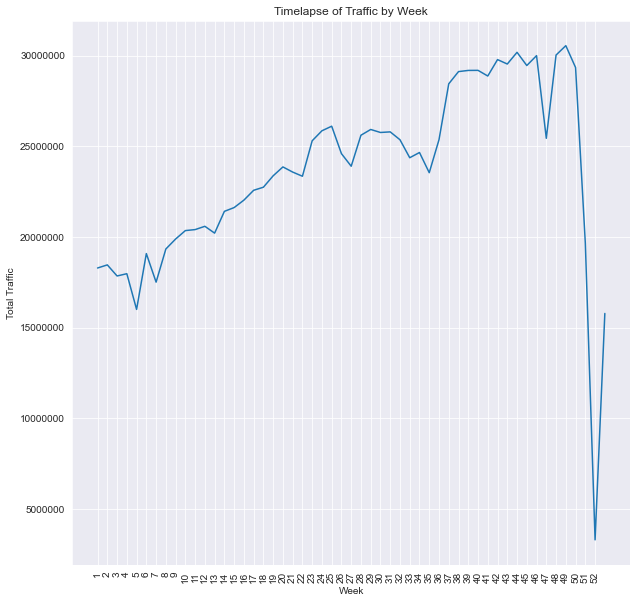

In [28]:
plt.figure(figsize=(10,10))
sns.lineplot(data=weekly_timelapse_df, x='week', y='net_traffic');
plt.title('Timelapse of Traffic by Week');
plt.xlabel('Week');
plt.ylabel('Total Traffic');
plt.ticklabel_format(axis='y', style='plain');
plt.xticks(np.linspace(1,52,52), rotation=90, fontsize=10);
plt.savefig('trafficbyweek.png');

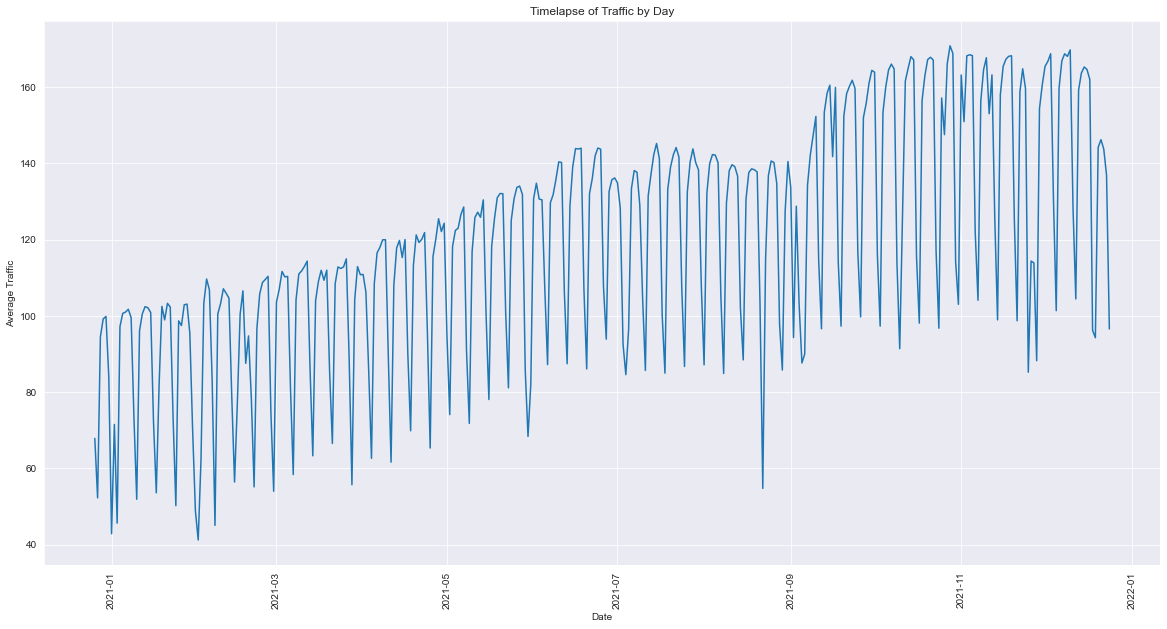

In [29]:
plt.figure(figsize=(20,10))
sns.lineplot(data=daily_timelapse_df, x='date', y='net_traffic');
plt.title('Timelapse of Traffic by Day')
plt.xlabel('Date')
plt.ylabel('Average Traffic')
plt.xticks(rotation=90);
plt.savefig('trafficbyday.png');

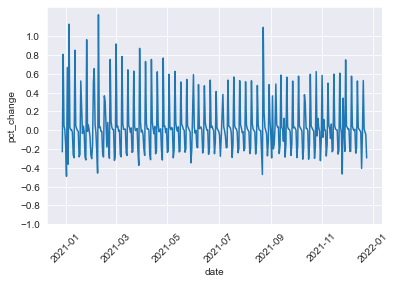

In [30]:
sns.lineplot(data=daily_timelapse_df, x='date', y='pct_change');
plt.xticks(rotation=45);
plt.yticks(np.linspace(-1,1,11));
plt.savefig('traffic_pct_change_by_day.png')

In [31]:
monthly_df = df.groupby(df.month)[['net_traffic']].sum().reset_index().copy()

In [32]:
monthly_df['pct_change'] = monthly_df.net_traffic.pct_change()
monthly_df['pct_change'].iloc[0] = 0
monthly_df['pct_total'] = monthly_df['net_traffic'].apply(lambda x: x / monthly_df.net_traffic.sum())

/Users/nathanieldirenzo/opt/anaconda3/envs/geo_env/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [33]:
monthly_timelapse = df.groupby(df.month)[['net_traffic']].mean().reset_index().copy()

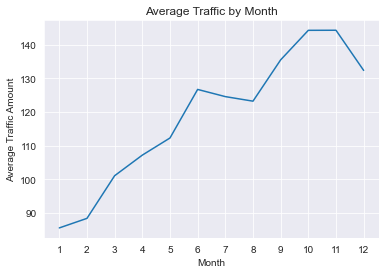

In [34]:
plt.plot(monthly_timelapse.month, monthly_timelapse.net_traffic);
plt.xlabel('Month')
plt.xticks(np.linspace(1,12,12));
plt.xlabel('Month');
plt.ylabel('Average Traffic Amount');
plt.title('Average Traffic by Month');
plt.savefig('avgtrafficbymonth.png')

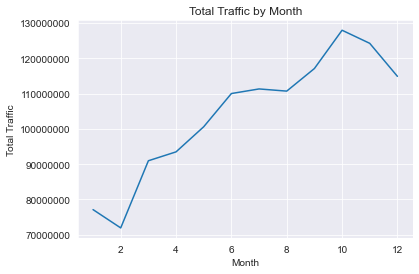

In [35]:
plt.plot(monthly_df.month, monthly_df.net_traffic);
plt.ticklabel_format(axis='y', style='plain');
plt.xlabel('Month');
plt.ylabel('Total Traffic');
plt.title('Total Traffic by Month');
plt.savefig('tot_traffic_by_month.png')

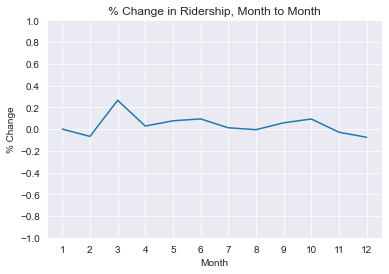

In [36]:
plt.plot(monthly_df['month'], monthly_df['pct_change']);
plt.xlabel('Month');
plt.xticks(np.linspace(1,12,12));
plt.ylabel('% Change')
plt.yticks(np.linspace(-1,1,11));
plt.title('% Change in Ridership, Month to Month');
plt.savefig('pct_change_months.png')

In [37]:
dayofweek_df = df.groupby(df.day_of_week)[['net_traffic']].sum()
dayofweek_df['pct_change'] = dayofweek_df.net_traffic.pct_change()
dayofweek_df['pct_change'].iloc[0] = ((dayofweek_df.net_traffic.iloc[0] - dayofweek_df.net_traffic.iloc[6]) / dayofweek_df.net_traffic.iloc[6])
dayofweek_df['pct_total'] = dayofweek_df['net_traffic'].apply(lambda x: x / dayofweek_df.net_traffic.sum())

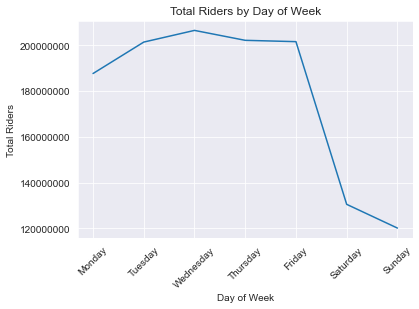

In [38]:
plt.plot(dayofweek_df.index, dayofweek_df.net_traffic);
plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45);
plt.ticklabel_format(axis='y', style='plain')
plt.xlabel('Day of Week')
plt.ylabel('Total Riders')
plt.title('Total Riders by Day of Week')
plt.savefig('ridersbydayofweek.png');

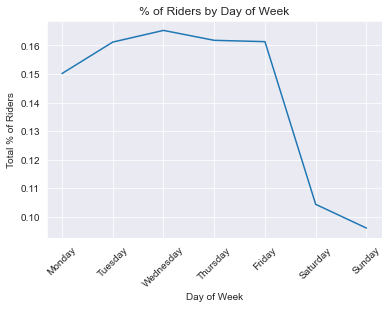

In [39]:
plt.plot(dayofweek_df.index, dayofweek_df.pct_total);
plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45);
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Total % of Riders');
plt.xlabel('Day of Week');
plt.title('% of Riders by Day of Week');
plt.savefig('pct_riders_dayofweek.png');

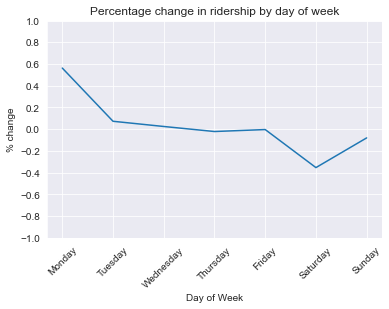

In [40]:
plt.plot(dayofweek_df.index, dayofweek_df['pct_change']);
plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45);
plt.xlabel('Day of Week');
plt.ylabel('% change');
plt.title('Percentage change in ridership by day of week');
plt.yticks(np.linspace(1,-1,11));
plt.savefig('pct_change_dayofweek.png');

In [41]:
top_stations = df.groupby('station')[['net_traffic']].sum().sort_values(by='net_traffic', ascending=False).reset_index().copy()
top_stations['pct_total'] = top_stations['net_traffic'].apply(lambda x: x / top_stations.net_traffic.sum())
top_stations['avg_daily'] = top_stations['net_traffic'].apply(lambda x: x/ 365)
top_stations.head()

station  net_traffic  pct_total     avg_daily
0   34_st_penn_sta   31672674.0   0.025329  86774.449315
1            23_st   20503199.0   0.016397  56173.147945
2            86_st   20391832.0   0.016308  55868.032877
3  grd_cntrl_42_st   19849892.0   0.015874  54383.265753
4  34_st_herald_sq   19430516.0   0.015539  53234.290411

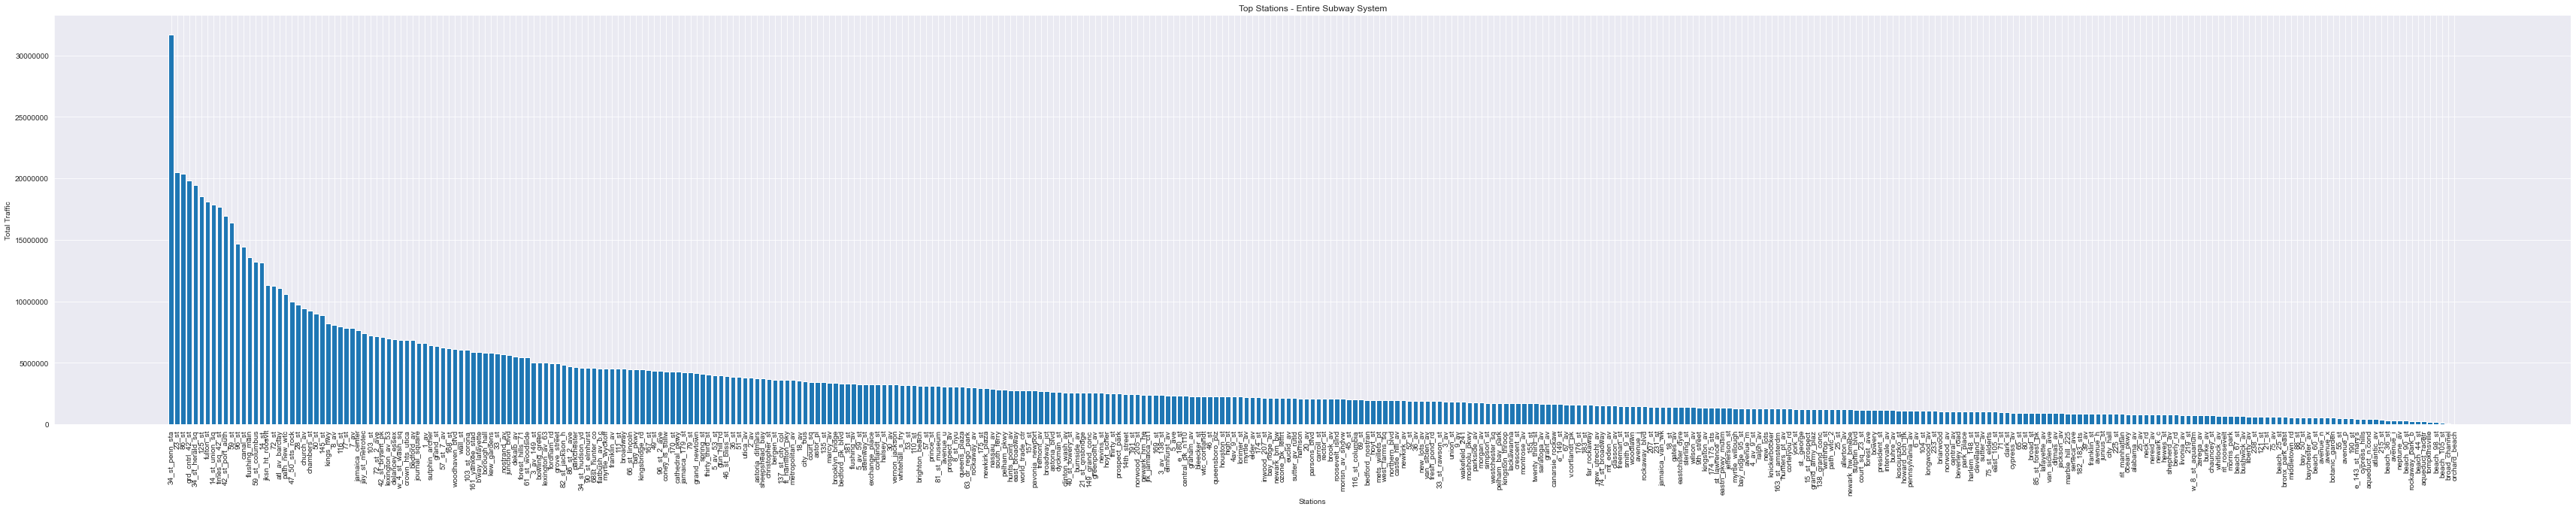

In [42]:
plt.figure(figsize=(60,10))
plt.bar(top_stations.station, top_stations.net_traffic);
plt.xticks(rotation=90);
plt.ticklabel_format(axis='y', style='plain');
plt.xlabel('Stations');
plt.ylabel('Total Traffic');
plt.title('Top Stations - Entire Subway System');
plt.savefig('topstations.png');

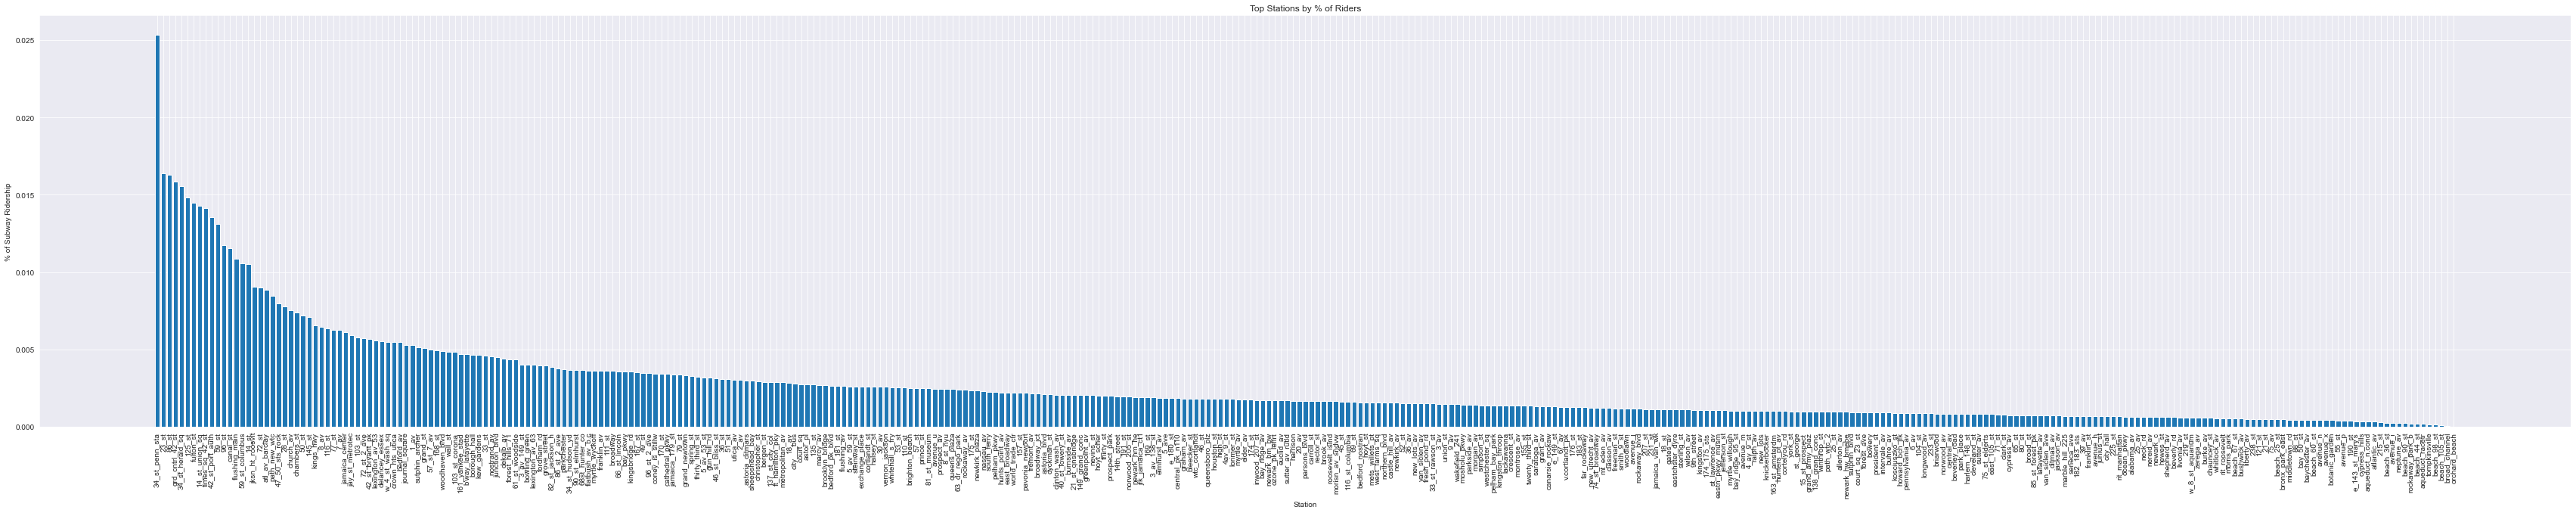

In [43]:
plt.figure(figsize=(60,10))
plt.bar(top_stations.station, top_stations.pct_total);
plt.xticks(rotation=90);
plt.ticklabel_format(axis='y', style='plain');
plt.xlabel('Station');
plt.ylabel('% of Subway Ridership');
plt.title('Top Stations by % of Riders');
plt.savefig('pct_tot_stations.png');

In [44]:
station_data = pd.read_csv('/Users/nathanieldirenzo/Documents/GitHub/NYC_MTA_EDA_Project/body.csv')

In [45]:
station_data.stop_name = station_data.stop_name.str.replace(" - ","_")
station_data.stop_name = station_data.stop_name.str.replace(" ","_")
station_data.stop_name = station_data.stop_name.str.replace("(","")
station_data.stop_name = station_data.stop_name.str.replace(")","")
station_data.stop_name = station_data.stop_name.str.replace("/","_")
station_data.stop_name = station_data.stop_name.str.replace(".","")
station_data.stop_name = station_data.stop_name.str.replace("-","_")
station_data.stop_name = station_data.stop_name.str.lower()

/Users/nathanieldirenzo/opt/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/nathanieldirenzo/opt/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.
/Users/nathanieldirenzo/opt/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be trea

In [46]:
mat1 = []
mat2 = []
p= []
list1 = top_stations.station.tolist()
list2 = station_data.stop_name.tolist()

In [47]:
threshold = 50

In [48]:
for i in list1:
    mat1.append(process.extractOne(i, list2, scorer=fuzz.ratio))
top_stations['matches'] = mat1

for j in top_stations['matches']:
    if j[1] >= threshold:
        p.append(j[0])
            
    mat2.append(','.join(p))
    p= []
    
top_stations['matches'] = mat2

In [49]:
top_station_df = pd.merge(top_stations, right=station_data, left_on='matches', right_on='stop_name', how='left')
top_station_df.avg_daily.head()

0    86774.449315
1    86774.449315
2    56173.147945
3    56173.147945
4    56173.147945
Name: avg_daily, dtype: float64

In [50]:
top_station_df = top_station_df.groupby(['station'])[['net_traffic', 'pct_total', 'borough', 'gtfs_longitude', 'gtfs_latitude', 'avg_daily']].first().sort_values(by='net_traffic', ascending=False).reset_index()



In [51]:
top_station_df['geometry'] = [Point(xy) for xy in zip(np.array(top_station_df['gtfs_longitude']), np.array(top_station_df['gtfs_latitude']))]

/Users/nathanieldirenzo/opt/anaconda3/envs/geo_env/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [52]:
nta_map = gpd.read_file('/Users/nathanieldirenzo/Documents/GitHub/NYC_MTA_EDA_Project/nynta2020.shp')
nta_map.to_crs(4326, inplace=True)

In [53]:
top_station_geo_df = gpd.GeoDataFrame(top_station_df, crs=4326, geometry = top_station_df.geometry)
top_station_geo_df.to_crs(4326, inplace=True)

In [54]:
top_station_geo_df.to_file("top_station.json", driver="GeoJSON")

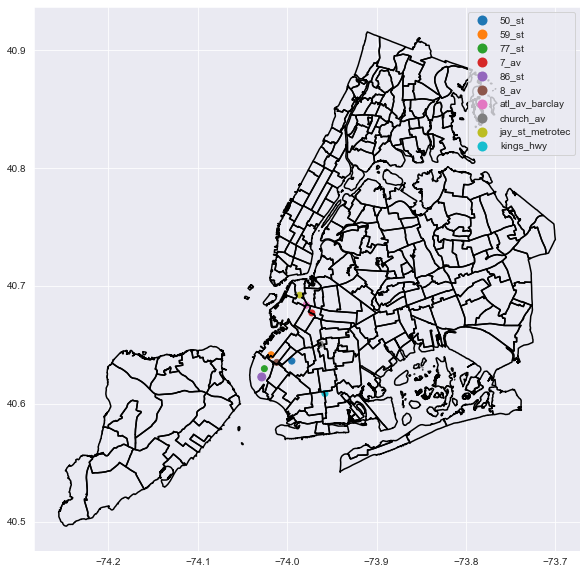

In [55]:
fig,ax = plt.subplots(figsize=(10,10))
nta_map.boundary.plot(ax=ax, edgecolor='k');
top_station_geo_df[top_station_geo_df.borough == 'Bk'].head(10).plot(column='station', ax=ax, legend=True, marker='.', markersize=top_station_geo_df.pct_total.astype('float') * 10000);
plt.savefig('bk_map.png');

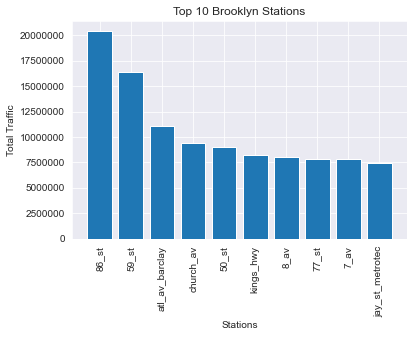

In [56]:
bk_df = top_station_df[top_station_df.borough == 'Bk'].copy()
bk_df.reset_index()
bk_df = bk_df.head(10)
plt.bar(bk_df.station, bk_df.net_traffic);
plt.title('Top 10 Brooklyn Stations')
plt.xlabel('Stations');
plt.ylabel('Total Traffic');
plt.xticks(rotation=90);
plt.ticklabel_format(axis='y', style='plain')
plt.savefig('bk_graph.png');

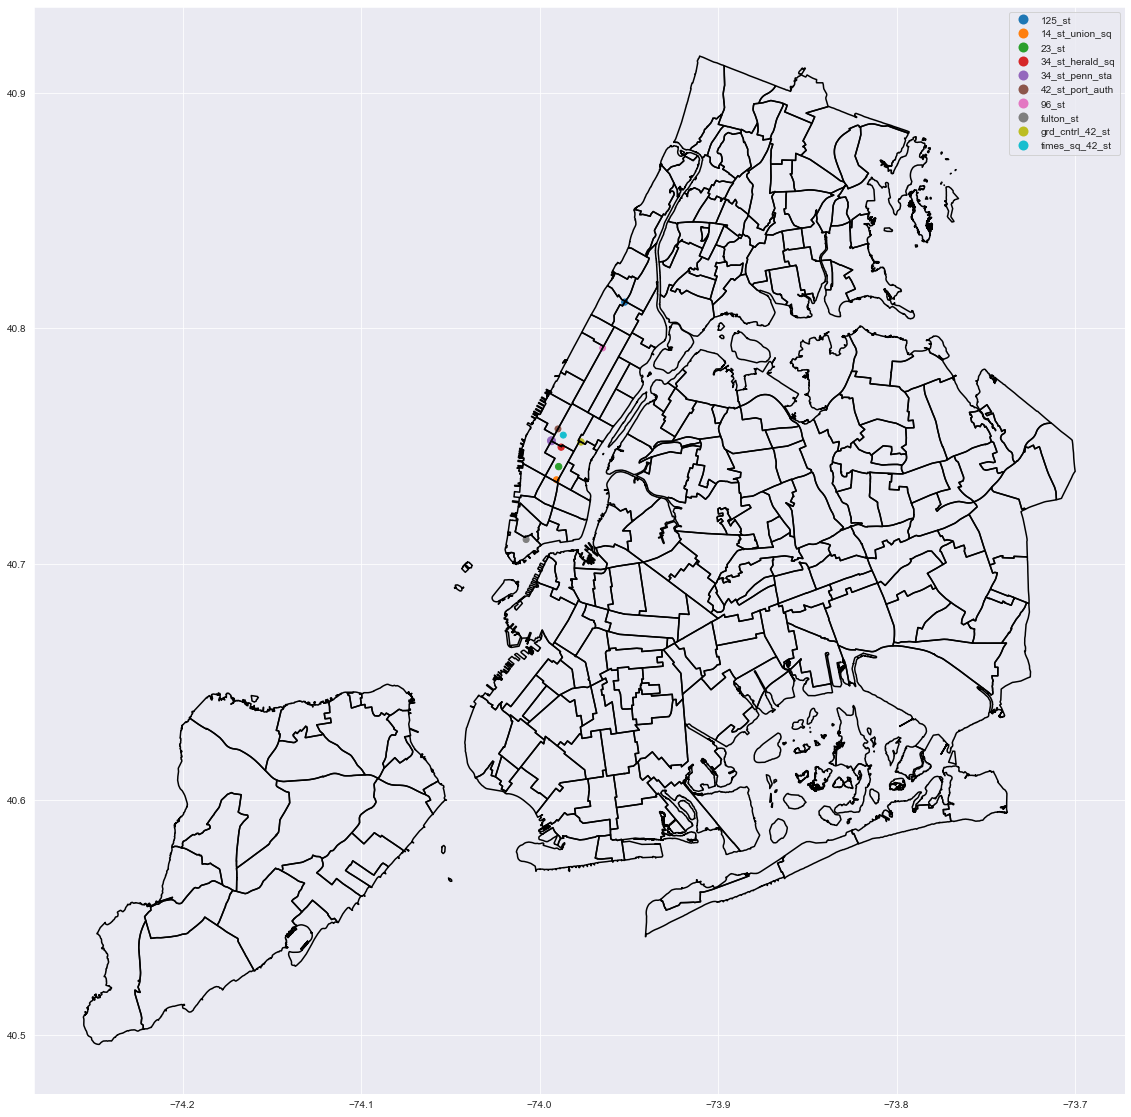

In [57]:
fig,ax = plt.subplots(figsize=(20,20))
nta_map.boundary.plot(ax=ax, edgecolor='k');
top_station_geo_df[top_station_geo_df.borough == 'M'].head(10).plot(column='station', ax=ax, legend=True, marker='.', markersize=top_station_geo_df.pct_total.astype('float') * 10000);
plt.savefig('mhn_map.png');

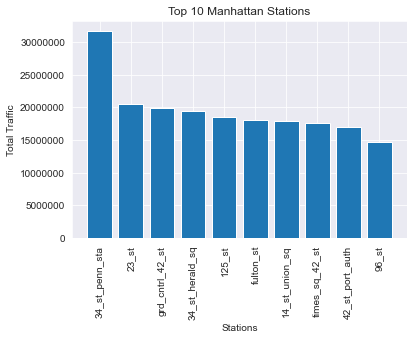

In [58]:
mhn_df = top_station_df[top_station_df.borough == 'M'].copy()
mhn_df.reset_index()
mhn_df = mhn_df.head(10)
#plt.figure(figsize=(50,10));
plt.bar(mhn_df.station, mhn_df.net_traffic);
plt.title('Top 10 Manhattan Stations')
plt.xlabel('Stations');
plt.ylabel('Total Traffic');
plt.xticks(rotation=90);
plt.ticklabel_format(axis='y', style='plain')
plt.savefig('mhn_graph.png');

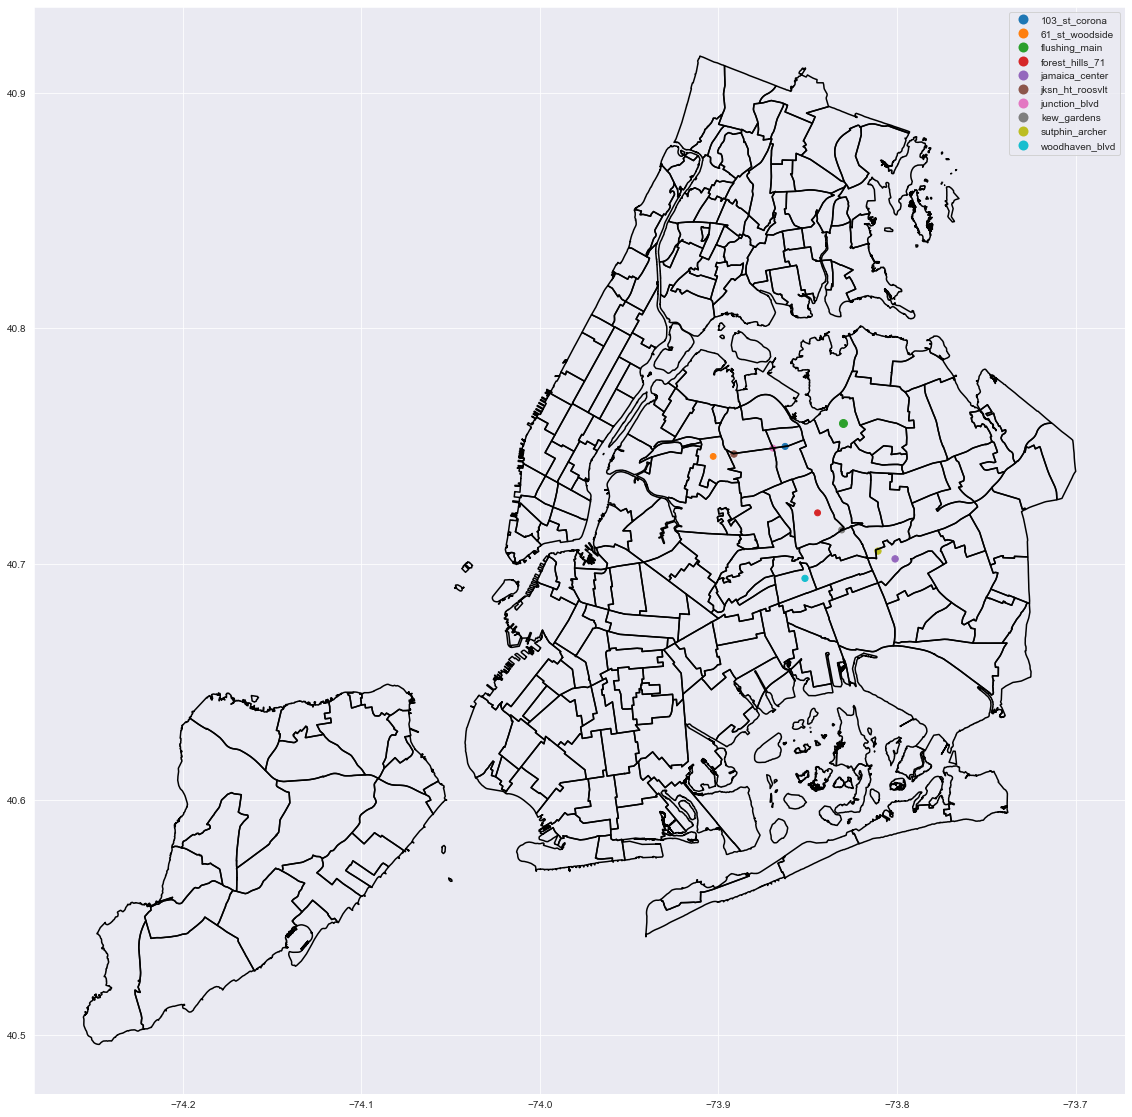

In [59]:
fig,ax = plt.subplots(figsize=(20,20))
nta_map.boundary.plot(ax=ax, edgecolor='k');
top_station_geo_df[top_station_geo_df.borough=='Q'].head(10).plot(column='station', ax=ax, legend=True, marker='.', markersize=top_station_geo_df.pct_total.astype('float') * 10000);
plt.savefig('q_map.png');

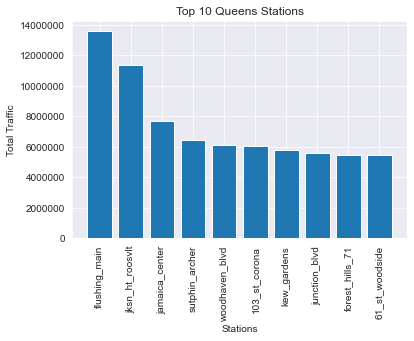

In [60]:
q_df = top_station_df[top_station_df.borough == 'Q'].copy()
q_df.reset_index()
q_df = q_df.head(10)
#plt.figure(figsize=(50,10));
plt.bar(q_df.station, q_df.net_traffic);
plt.title('Top 10 Queens Stations')
plt.xlabel('Stations');
plt.ylabel('Total Traffic');
plt.xticks(rotation=90);
plt.ticklabel_format(axis='y', style='plain')
plt.savefig('q_graph.png');

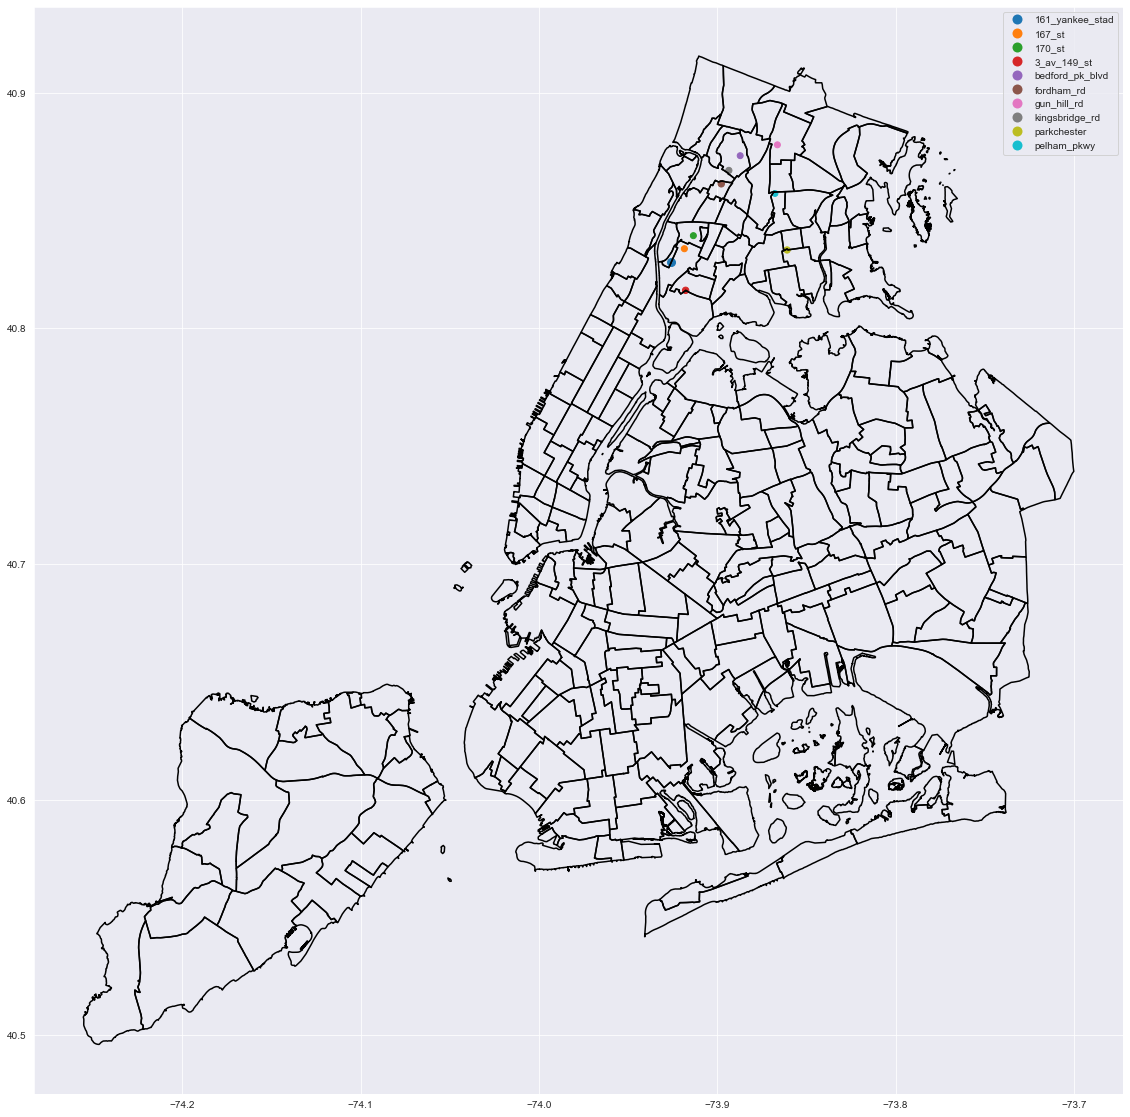

In [61]:
fig,ax = plt.subplots(figsize=(20,20))
nta_map.boundary.plot(ax=ax, edgecolor='k');
top_station_geo_df[top_station_geo_df.borough == 'Bx'].head(10).plot(column='station', ax=ax, legend=True, marker='.', markersize=top_station_geo_df.pct_total.astype('float') * 10000);
plt.savefig('bx_map.png');


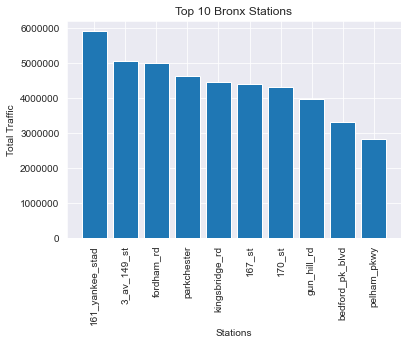

In [62]:
bx_df = top_station_df[top_station_df.borough == 'Bx'].copy()
bx_df.reset_index()
bx_df = bx_df.head(10)
#plt.figure(figsize=(50,10));
plt.bar(bx_df.station, bx_df.net_traffic);
plt.title('Top 10 Bronx Stations')
plt.xlabel('Stations');
plt.ylabel('Total Traffic');
plt.xticks(rotation=90);
plt.ticklabel_format(axis='y', style='plain')
plt.savefig('bx_graph.png');

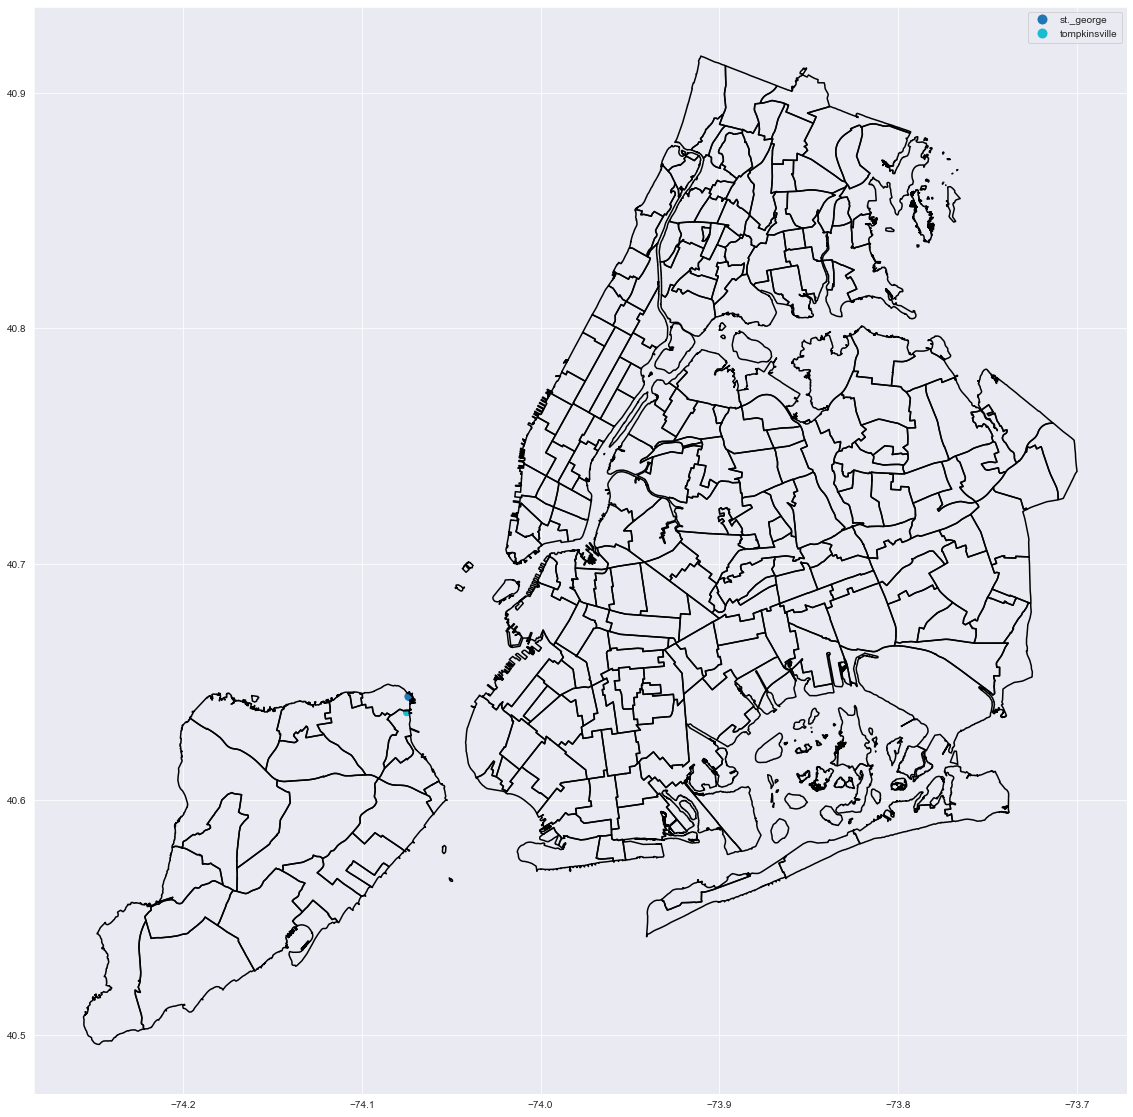

In [63]:
fig,ax = plt.subplots(figsize=(20,20))
nta_map.boundary.plot(ax=ax, edgecolor='k');
top_station_geo_df[top_station_geo_df.borough == 'SI'].head(10).plot(column='station', ax=ax, legend=True, marker='.', markersize=top_station_geo_df.pct_total.astype('float') * 10000);
plt.savefig('si_map.png');




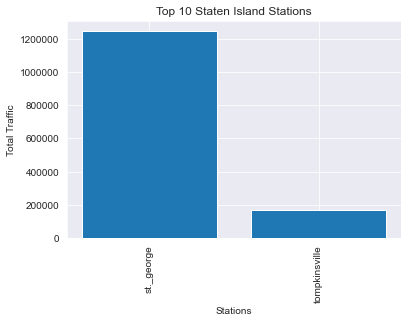

In [64]:
si_df = top_station_df[top_station_df.borough == 'SI'].copy()
si_df.reset_index()
si_df = si_df.head(10)
#plt.figure(figsize=(50,10));
plt.bar(si_df.station, si_df.net_traffic);
plt.title('Top 10 Staten Island Stations')
plt.xlabel('Stations');
plt.ylabel('Total Traffic');
plt.xticks(rotation=90);
plt.ticklabel_format(axis='y', style='plain')
plt.savefig('si_graph.png');

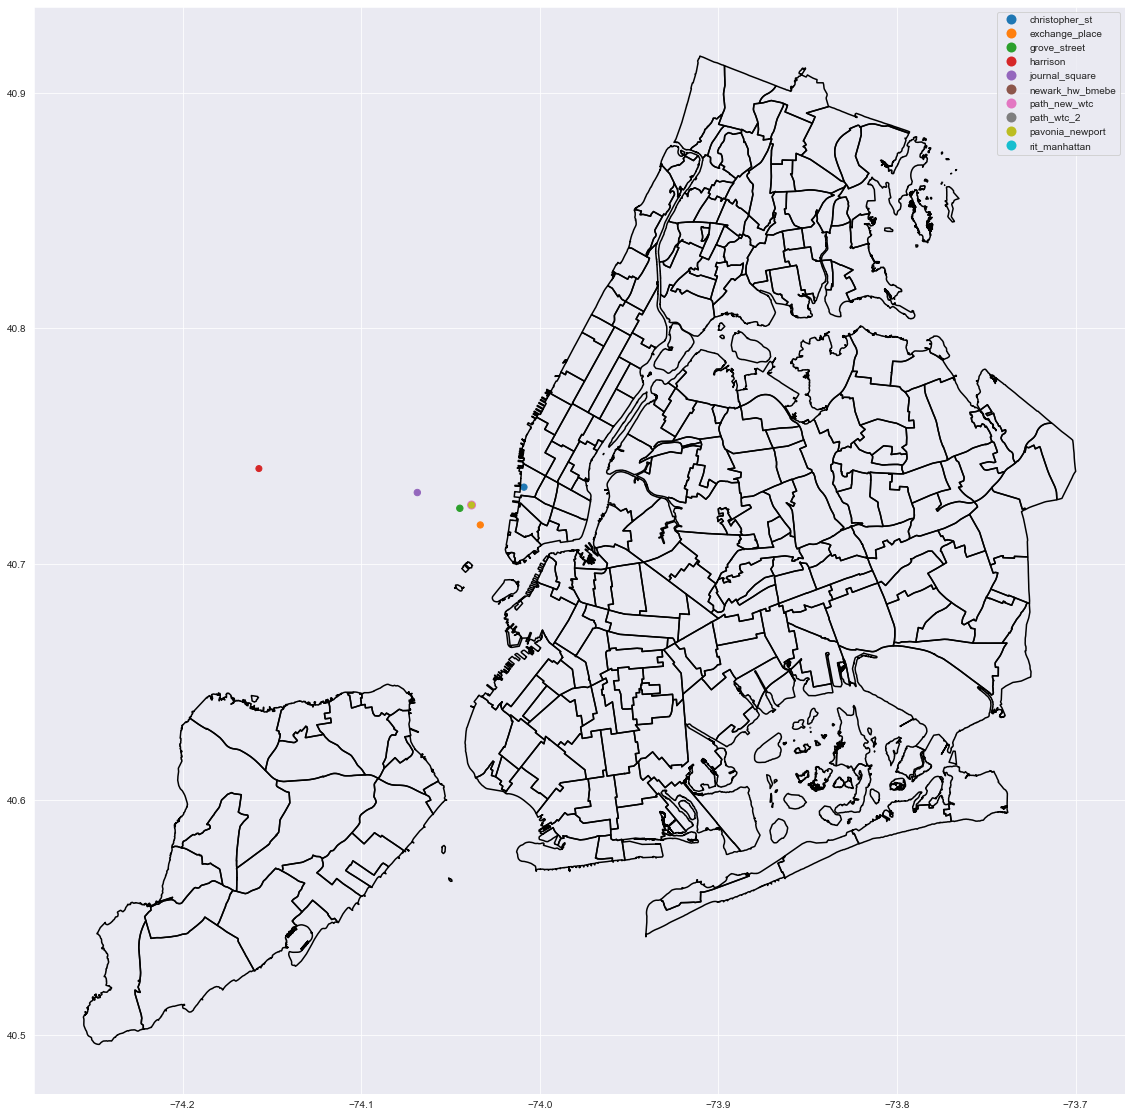

In [65]:
fig,ax = plt.subplots(figsize=(20,20));
nta_map.boundary.plot(ax=ax, edgecolor='k');
top_station_geo_df[top_station_geo_df.borough.isna() == True].head(10).plot(column='station', ax=ax, legend=True, marker='.', markersize=top_station_geo_df.pct_total.astype('float') * 10000);
plt.savefig('misc_map.png');

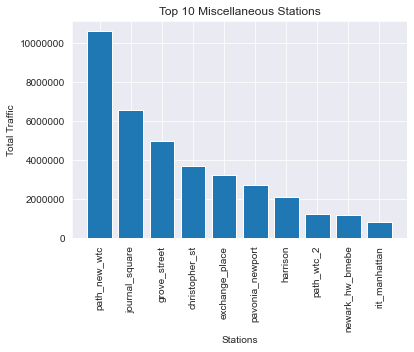

In [66]:
na_df = top_station_df[top_station_df.borough.isna() == True].copy()
na_df.reset_index()
na_df = na_df.head(10)
#plt.figure(figsize=(50,10));
plt.bar(na_df.station, na_df.net_traffic);
plt.title('Top 10 Miscellaneous Stations')
plt.xlabel('Stations');
plt.ylabel('Total Traffic');
plt.xticks(rotation=90);
plt.ticklabel_format(axis='y', style='plain')
plt.savefig('misc_graph.png');

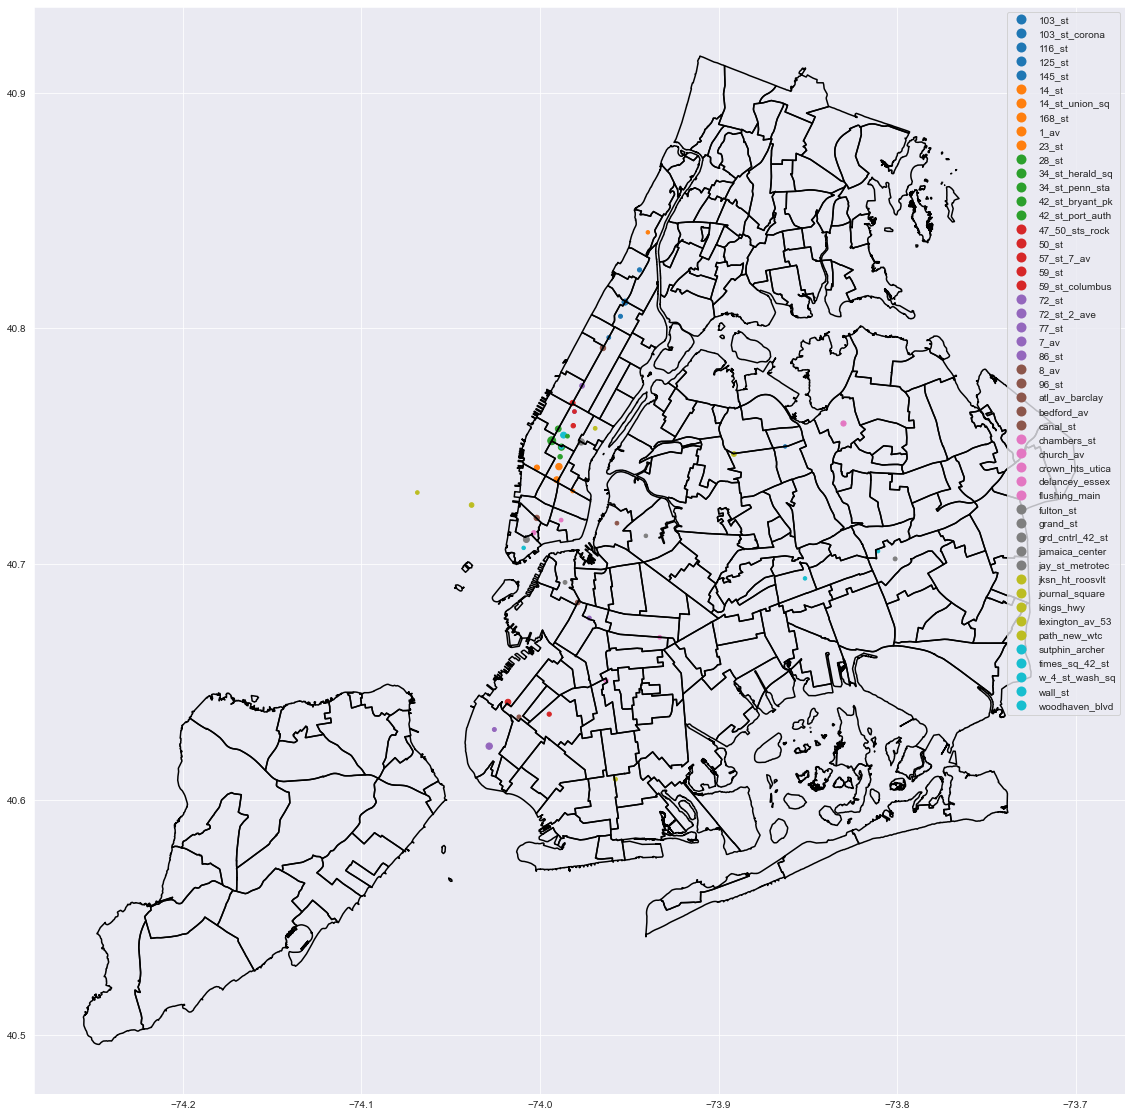

In [67]:
fig,ax = plt.subplots(figsize=(20,20));
nta_map.boundary.plot(ax=ax, edgecolor='k');
top_station_geo_df.head(50).plot(column='station', ax=ax, legend=True, marker='.', markersize=top_station_geo_df.pct_total.astype('float') * 10000);
plt.savefig('all_map.png');



In [68]:
nta_demos = pd.read_excel('https://www1.nyc.gov/assets/planning/download/office/planning-level/nyc-population/acs/demo_2019_acs5yr_nta.xlsx')

In [69]:
nta_df = nta_map.merge(nta_demos, how='left', left_on='NTA2020', right_on='GeoID')

In [70]:
m = leafmap.Map(center=(40,-100),zoom=4)

In [71]:
m.add_gdf(nta_df, layer_name='2020 NTA Demographic Information', info_mode='on_click')
m.add_point_layer(filename='/Users/nathanieldirenzo/Documents/GitHub/NYC_MTA_EDA_Project/top_station.json', popup=['station', 'net_traffic', 'pct_total', 'avg_daily'], layer_name="Stations")


In [72]:
m

Map(center=[40, -100], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [73]:
m.save('final_map.html', title='2021 MTA Turnstile + 2020 Census Demographic Information')